### 1.0 Imports

In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from math import radians, cos, sin, asin, sqrt

### 2.0 Load Data

Loading in the cleaned, exported data from my data wrangling step.

In [157]:
#load trees data
trees_data = pd.read_csv('../data/data_outputs/seattle_trees.csv')

#load climate data
climate_data = pd.read_csv('../data/data_outputs/washington_climate_normals.csv')

### 3.0 Explore and Combine Data

The first step I have in mind is creating a field that maps each trees to its nearest weather station from my climate normals data.

#### 3.1 Tie Together The Two Dataframes Using Lat-Lon

##### 3.1.1 Define Functions

In [158]:
def dist_b_points(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees). 
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [217]:
def flag_nearest(lat, long):
    """ 
    Label the closest weather station using the reults of the dist_b_points function.
    df_b =  the df to which to search for the closest point (in this case climate_data)
    field_b =  the name of the field in which you want to flag as nearest (in this case STATION)
    Credit https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546
    """
    distances = climate_data.apply(
        lambda row: dist_b_points(lat, long, row['lat_climate'], row['long_climate']), axis = 1)
    return climate_data.loc[distances.idxmin(), 'STATION']

##### 3.1.2 Rename Lat-Lons Fields

In [160]:
#Need a reminder of my fields
trees_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162080 entries, 0 to 162079
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   planted_date               159111 non-null  object 
 1   most_recent_observation    162075 non-null  object 
 2   common_name                161408 non-null  object 
 3   longitude_coordinate       162080 non-null  float64
 4   latitude_coordinate        162080 non-null  float64
 5   diameter_breast_height_CM  162080 non-null  float64
 6   condition                  162080 non-null  object 
 7   native                     162080 non-null  object 
 8   age_at_obs                 159106 non-null  float64
 9   condition_index            162080 non-null  float64
dtypes: float64(5), object(5)
memory usage: 12.4+ MB


In [161]:
climate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          33 non-null     object 
 1   LATITUDE         33 non-null     float64
 2   LONGITUDE        33 non-null     float64
 3   ELEVATION        33 non-null     float64
 4   NAME             33 non-null     object 
 5   ANN-TAVG-NORMAL  33 non-null     float64
 6   ANN-TMIN-NORMAL  33 non-null     float64
 7   ANN-TMAX-NORMAL  33 non-null     float64
 8   ANN-DUTR-NORMAL  33 non-null     float64
 9   ANN-PRCP-NORMAL  32 non-null     float64
dtypes: float64(8), object(2)
memory usage: 2.7+ KB


In [162]:
#Rename lat-long fields to easily identify between dfs
trees_data.rename(columns = {'longitude_coordinate': 'long_trees', 'latitude_coordinate': 'lat_trees'}, inplace=True)
climate_data.rename(columns = {'LONGITUDE': 'long_climate', 'LATITUDE': 'lat_climate'}, inplace=True)

##### 3.1.3 Assign Each Tree Record a Unique ID

I'm thinking in order to map back into our dataframe the closest station, I'll need to do it off a primary key and I'd rather not do that just off the location.

In [163]:

#Assign the key numerically, using the index number +1 (to exclude 0)
trees_data['tree_id'] = trees_data.index+1

In [164]:
#let's also change this to an object
trees_data['tree_id'] = trees_data['tree_id'].astype(object)

In [165]:
#Double check values are unique
trees_data['tree_id'].value_counts()

1         1
108057    1
108050    1
108051    1
108052    1
         ..
54028     1
54029     1
54030     1
54031     1
162080    1
Name: tree_id, Length: 162080, dtype: int64

In [166]:
trees_data.dtypes

planted_date                  object
most_recent_observation       object
common_name                   object
long_trees                   float64
lat_trees                    float64
diameter_breast_height_CM    float64
condition                     object
native                        object
age_at_obs                   float64
condition_index              float64
tree_id                       object
dtype: object

##### 3.1.4 Map the Nearest Station to Each Tree Record

In [218]:
trees_data['nearest_station'] = trees_data.apply(
    lambda row: flag_nearest(row['lat_trees'], row['long_trees']), axis=1)

In [219]:
trees_data['nearest_station'].value_counts()

USW00094290    100326
USW00024234     60464
USW00094248      1290
Name: nearest_station, dtype: int64

I'm surprised this only mapped in 3 location as the nearest. Let's merge in the rest of the climate data and see if this makes sense.

##### 3.1.5 Merge Datasets Into a Single Table

In [220]:
#left join on tree_id to pull in all data, let's see if this works and isn't too big.
trees_climate_all = pd.merge(trees_data, climate_data, left_on='nearest_station', right_on='STATION', how='left')

In [222]:
trees_climate_all['NAME'].value_counts()

SEATTLE SAND PT WSFO, WA US    100326
SEATTLE BOEING FLD, WA US       60464
RENTON MUNI AP, WA US            1290
Name: NAME, dtype: int64

##### 3.1.6 Validate Visually

I want to plot both the stations an the trees on the same plot/map to see if these make sense visually.

In [238]:
crs = {'init': 'epsg:4326'} #standardization for geo data
geometry1 = [Point(xy) for xy in zip(trees_data['long_trees'], trees_data['lat_trees'])] #create points for trees location
geometry2 = [Point(xy) for xy in zip(climate_data['long_climate'], climate_data['lat_climate'])] #create points for weather stations

print(geometry1[:3])
print(geometry2[:3])

[<POINT (-122.282 47.635)>, <POINT (-122.31 47.598)>, <POINT (-122.355 47.674)>]
[<POINT (-119.517 48.461)>, <POINT (-123.812 47.514)>, <POINT (-121.446 48.541)>]


In [234]:
trees_geo_df = gpd.GeoDataFrame(trees_data, crs=crs, geometry=geometry1)
stations_geo_df = gpd.GeoDataFrame(climate_data, crs = crs, geometry=geometry2)

/Users/brettly/opt/anaconda3/envs/ds/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


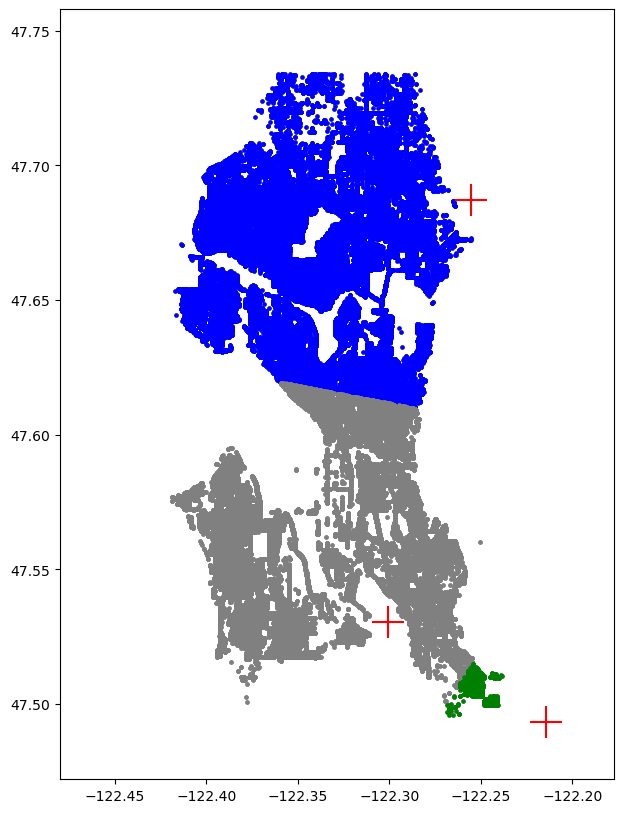

In [250]:
fig, ax = plt.subplots(figsize = (10,10))
trees_geo_df.plot(ax=ax, markersize=5, color='gray', marker='o')
trees_geo_df[trees_geo_df['nearest_station'] == 'USW00094290'].plot(ax=ax, markersize=5, color='blue', marker='o')
trees_geo_df[trees_geo_df['nearest_station'] == 'USW00024234'].plot(ax=ax, markersize=5, color='gray', marker='o') 
trees_geo_df[trees_geo_df['nearest_station'] == 'USW00094248'].plot(ax=ax, markersize=5, color='green', marker='o')

stations_geo_df.plot(ax=ax, markersize=500, color='red', marker='+')

#zoom into rough seattle area by adding some space around the min and max values
plt.axis([trees_data['long_trees'].min()*1.0005, trees_data['long_trees'].max()*.9995, trees_data['lat_trees'].min()*0.9995, trees_data['lat_trees'].max()*1.0005])

plt.show()